# Classifiers entrainés mis en cascade pour une évaluation sur le DataSet de test

## Loader

### Gestion de l'accès au drive / import des bibliothèques / Gestion de l'accès au GPU

In [2]:
########## Accès au drive ########
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
########## Positionnement dans le repertoire ########
%cd /content/drive/MyDrive/TSP/HTI/PFE
#%cd /content/drive/MyDrive/PFE
!ls

/content/drive/MyDrive/TSP/HTI/PFE
API				log.txt			    resnet18_0.1_tiktok.pth
API-Database			__pycache__		    resnet18_0.1_vidmizer.pth
Cascade.ipynb			resnet180.0001.pth	    resnet180.1vidmizer_test.pth
Classifier_2D_c_tiktok.ipynb	resnet180.0001tiktok.pth    resnet18_0.1_youtube.pth
Classifier_2D_c_vidmizer.ipynb	resnet180.0001vidmizer.pth  test_tiktok
Classifier_2D_c_youtube.ipynb	resnet180.001.pth	    test_vidmizer
Database_2D			resnet180.001tiktok.pth     test_youtube
final_test			resnet180.001vidmizer.pth   train_tiktok
final_test_2			resnet180.01.pth	    train_vidmizer
Loader_2D_C.py			resnet180.01tiktok.pth	    train_youtube
logs.txt			resnet180.01vidmizer.pth


In [4]:
###### Librairies #######
import os
import pandas as pd
from torchvision.io import read_image
import torch
import numpy as np
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
#########################

In [5]:
########## Gestion du GPU ###########
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # see if gpu is available
print('Using gpu: %s ' % torch.cuda.is_available())

Using gpu: True 


### Fonctions de Customisation de Dataset et de Loader

In [6]:
########### Importation de la Classe Customisée ######
import sys
sys.path.append('Loader_2D_C.py')
print(sys.path)
from Loader_2D_C import CustomImageDataset

['/content', '/env/python', '/usr/lib/python310.zip', '/usr/lib/python3.10', '/usr/lib/python3.10/lib-dynload', '', '/usr/local/lib/python3.10/dist-packages', '/usr/lib/python3/dist-packages', '/usr/local/lib/python3.10/dist-packages/IPython/extensions', '/root/.ipython', 'Loader_2D_C.py']


In [7]:
################# Modification selon la classe  du RESNET #########
###### Attention il faut le dataset avec les trois classes ########
########## Path ##########

# dataset_test_2D = './final_test'
dataset_test_2D = './final_test_2'
annotation_test = dataset_test_2D + '/label_final_test.txt'


In [8]:
# Initialiser des variables pour accumuler les sommes et les sommes des carrés
# sum_of_pixels = 0
# sum_of_squares = 0
# num_of_pixels = 0

# # Parcourir le répertoire et charger chaque fichier .npy
# for filename in os.listdir(dataset_test_2D):
#     if filename.endswith('.npy'):
#         filepath = os.path.join(dataset_test_2D, filename)
#         data = np.load(filepath)  # Charger le fichier .npy

#         # Accumuler les valeurs
#         sum_of_pixels += np.sum(data)
#         sum_of_squares += np.sum(data ** 2)
#         num_of_pixels += data.size


# # Calcul de la moyenne et de l'écart-type
# mean = sum_of_pixels / num_of_pixels
# std = np.sqrt((sum_of_squares / num_of_pixels) - (mean ** 2))
# print()
# print(f'Mean: {mean:.3f}, Std: {std:.3f}')

In [9]:
##### Image preprocessing #####
from torchvision import transforms
preprocess = transforms.Compose([
        transforms.ToTensor(),
        transforms.Resize(576, antialias=True),  # image batch, resize smaller edge to 576
        transforms.CenterCrop(576),  # image batch, center crop to square 576x576
        # transforms.Normalize(mean=[mean, mean, mean], std=[std, std, std])
])

In [10]:
############## Paramètre ################
batch_size = 1

############## Test Part ################

test_set = CustomImageDataset(
    annotations_file = annotation_test,
    npy_dir = dataset_test_2D,
    transform=preprocess
)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

## Cascade Classifier

### Chemin des modèles saved et chargement

In [11]:
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from tqdm import tqdm

In [12]:
########## Path ##########
path_vidmizer_saved = './resnet18_0.1_vidmizer.pth'
path_tiktok_saved = './resnet18_0.1_tiktok.pth'
path_ytb_saved = './resnet18_0.1_youtube.pth'

# vidmizer 0
# tikotk 1
# youtube 2
# rien 3
##########################

In [13]:
import torchvision.models as models
import torch.nn as nn

######## Loading ###########
# Créer une instance du modèle
net_vidmizer = models.resnet18(weights=None)
num_ftrs = net_vidmizer.fc.in_features
net_vidmizer.fc = nn.Linear(num_ftrs, 2)

# Charger l'état du modèle sauvegardé
net_vidmizer.load_state_dict(torch.load(path_vidmizer_saved))

######## Loading ###########
# Créer une instance du modèle
net_tiktok = models.resnet18(weights=None)
num_ftrs = net_tiktok.fc.in_features
net_tiktok.fc = nn.Linear(num_ftrs, 2)

# Charger l'état du modèle sauvegardé
net_tiktok.load_state_dict(torch.load(path_tiktok_saved))

######## Loading ###########
# Créer une instance du modèle
net_ytb = models.resnet18(weights=None)
num_ftrs = net_ytb.fc.in_features
net_ytb.fc = nn.Linear(num_ftrs, 2)

# Charger l'état du modèle sauvegardé
net_ytb.load_state_dict(torch.load(path_ytb_saved))########################

<All keys matched successfully>

In [14]:
num_class = 4

def quality_measurement(confusion_matrix):
    line_sum=torch.sum(confusion_matrix,dim=1)
    column_sum = torch.sum(confusion_matrix, dim=0)
    total_sum=torch.sum(confusion_matrix)
    Accuracy=torch.sum(torch.diag(confusion_matrix))/total_sum
    Precision=torch.diag(confusion_matrix)/line_sum
    Recall=torch.diag(confusion_matrix)/column_sum
    F1_score = 2 * (Precision * Recall)/(Precision+Recall)
    Pfa=(line_sum - torch.diag(confusion_matrix))/total_sum
    Pmd=(column_sum - torch.diag(confusion_matrix))/total_sum
    print("Accuracy : {}".format(Accuracy.item()))
    print("Precision 0 : {} - Precision 1 : {}".format(Precision[0],Precision[1]))
    print("Recall 0 : {} - Recall 1 : {}".format(Recall[0], Recall[1]))
    print("F1 score 0 : {} - F1 score 1 : {}".format(F1_score[0], F1_score[1]))
    print("Pfa 0 : {} - Pfa 1 : {}".format(Pfa[0], Pfa[1]))
    print("Pmd 0 : {} - Pmd 1 : {}".format(Pmd[0], Pmd[1]))
    return torch.nanmean(Accuracy),torch.nanmean(Precision),torch.nanmean(Recall),torch.nanmean(Recall),torch.nanmean(Pfa),torch.nanmean(Pmd)

In [15]:
import torch
import torchvision.transforms as transforms

#Normalisation des données

# Supposons que ces soient vos valeurs calculées pour chaque réseau
mean_vidmizer, std_vidmizer = [-0.111, -0.111, -0.111], [18.606, 18.606, 18.606] #Mean: -0.111, Std: 18.606
mean_tiktok, std_tiktok = [-0.057, -0.057, -0.057], [17.523, 17.523, 17.523] #Mean: -0.057, Std: 17.523
mean_youtube, std_youtube = [-0.074, -0.074, -0.074], [17.024, 17.024, 17.024] #Mean: -0.074, Std: 17.024

mean_list = [mean_vidmizer, mean_tiktok, mean_youtube]
std_list = [std_vidmizer, std_tiktok, std_youtube]
# Créer les transformations pour chaque réseau
transform_vidmizer = transforms.Normalize(mean_vidmizer, std_vidmizer)
transform_tiktok = transforms.Normalize(mean_tiktok, std_tiktok)
transform_youtube = transforms.Normalize(mean_youtube, std_youtube)

transforms_list = [transform_vidmizer, transform_tiktok, transform_youtube]

# fonction de dénormalisation pour le passage à travers un deuxième classificateur
def denormalize(tensor, mean, std):
    """Inverse de la normalisation pour une image tensor."""
    denormalized = tensor.clone()
    for t, m, s in zip(denormalized, mean, std):
        t.mul_(s).add_(m)  # Inverse de la normalisation
    return denormalized

In [58]:
# import torch.nn.functional as F

# net_vidmizer.to(device)
# net_tiktok.to(device)
# net_ytb.to(device)

# net_tiktok.eval()
# net_vidmizer.eval()
# net_ytb.eval()

# nets = [net_vidmizer, net_tiktok, net_ytb]


# eval_labels = []
# confusion_matrix = torch.zeros((num_class, num_class), device=device)

# with torch.no_grad():
#     for data in test_loader:
#         images, labels = data
#         images = images.to(device)
#         labels = labels.to(device)

#         for i in range(len(labels)):
#             image = images[i].unsqueeze(0)
#             label = int(labels[i])

#             confidences = []
#             for net_id, net in enumerate(nets):
#                 if net_id > 0:
#                     image = denormalize(image, mean_previous, std_previous)

#                 image = transforms_list[net_id](image) #to applay the normalization
#                 mean_previous, std_previous = mean_list[net_id], std_list[net_id] # to store the values of mean and std for denormalization

#                 outputs = net(image) #output

#                 probabilities = F.softmax(outputs, dim=1) #get the proba to get the confidance
#                 confidence, predicted = torch.max(probabilities, 1)
#                 label_predicted = int(predicted[0])
#                 confidences.append(float(confidence))

#                 if label_predicted == 0:
#                     eval_labels.append((net_id, label, confidences))
#                     confusion_matrix[label][net_id] += 1
#                     break
#             else:  # Si aucune classe n'est prédite
#                 eval_labels.append((3, label, confidences))  # Classe 'meta' avec les trois confiances
#                 confusion_matrix[label][3] += 1

# net_tiktok.train()
# net_vidmizer.train()
# net_ytb.train()

# print(len(eval_labels))
# for item in eval_labels:
#     print(item)


32
(0, 3, [0.7916772961616516])
(1, 3, [0.9031025767326355, 0.7040735483169556])
(0, 3, [0.5201096534729004])
(0, 3, [0.5677438974380493])
(0, 3, [0.7088271379470825])
(1, 3, [1.0, 1.0])
(1, 3, [1.0, 1.0])
(1, 3, [0.9999998807907104, 1.0])
(0, 1, [0.7916772961616516])
(1, 1, [0.9999997615814209, 1.0])
(0, 1, [0.7167462706565857])
(1, 1, [1.0, 1.0])
(1, 1, [0.9665538668632507, 1.0])
(1, 1, [0.9941040873527527, 0.9999854564666748])
(1, 1, [1.0, 1.0])
(1, 1, [0.9999998807907104, 1.0])
(0, 0, [0.9999560117721558])
(0, 0, [0.8664082288742065])
(0, 0, [0.8748656511306763])
(0, 0, [0.9999862909317017])
(0, 0, [0.999818742275238])
(0, 0, [0.9994650483131409])
(0, 0, [0.9998394250869751])
(0, 0, [0.9798055291175842])
(0, 2, [0.5125865340232849])
(0, 2, [0.7841648459434509])
(0, 2, [0.704971969127655])
(0, 2, [0.7050794363021851])
(0, 2, [0.7153211236000061])
(2, 2, [0.9855870008468628, 0.6532450318336487, 0.9543945789337158])
(2, 2, [0.9875807762145996, 0.8181267976760864, 0.9356935620307922])


In [18]:
import itertools
import torch
import torch.nn.functional as F

#vidmizer : 0
#tiktok : 1
#youtube : 2
#meta : 3


# Supposons que vos modèles et autres paramètres sont définis ici
# net_vidmizer, net_tiktok, net_ytb, transform_vidmizer, transform_tiktok, transform_youtube
# mean_vidmizer, std_vidmizer, mean_tiktok, std_tiktok, mean_youtube, std_youtube
net_vidmizer.to(device)
net_tiktok.to(device)
net_ytb.to(device)

net_tiktok.eval()
net_vidmizer.eval()
net_ytb.eval()

# Créer une liste qui regroupe les modèles avec leurs transformations et paramètres de normalisation
model_info = [
    (0, net_vidmizer, transform_vidmizer, mean_vidmizer, std_vidmizer),
    (1, net_tiktok, transform_tiktok, mean_tiktok, std_tiktok),
    (2, net_ytb, transform_youtube, mean_youtube, std_youtube)
]

# Générer toutes les permutations possibles
permutations = list(itertools.permutations(model_info))

# Ouvrir un fichier log pour enregistrer les résultats
with open('logs.txt', 'w') as log_file:
    for perm in permutations:
        # Réinitialiser eval_labels et confusion_matrix pour chaque permutation
        eval_labels = []
        confusion_matrix = torch.zeros((num_class, num_class), device=device)

        with torch.no_grad():
            for data in test_loader:
                images, labels = data
                images = images.to(device)
                labels = labels.to(device)

                for i in range(len(labels)):
                    image = images[i].unsqueeze(0)
                    label = int(labels[i])
                    confidences = []

                    for model_name, net, transform, mean, std in perm:

                        image = transform(image)
                        outputs = net(image)
                        probabilities = F.softmax(outputs, dim=1)
                        confidence, predicted = torch.max(probabilities, 1)
                        label_predicted = int(predicted[0])
                        confidences.append(float(confidence))
                        image = denormalize(image, mean, std)

                        if label_predicted == 0:
                            eval_labels.append((model_name, label, confidences))
                            confusion_matrix[label][perm.index((model_name, net, transform, mean, std))] += 1
                            break
                    else:
                        eval_labels.append((3, label, confidences))
                        confusion_matrix[label][3] += 1

        # Enregistrer les résultats de la permutation actuelle dans le fichier log
        log_file.write(f"Permutation: {[model_name for model_name, _, _, _, _ in perm]}\n")
        log_file.write(f"Confusion Matrix:\n{confusion_matrix}\n")
        for item in eval_labels:
            log_file.write(f"{item}\n")


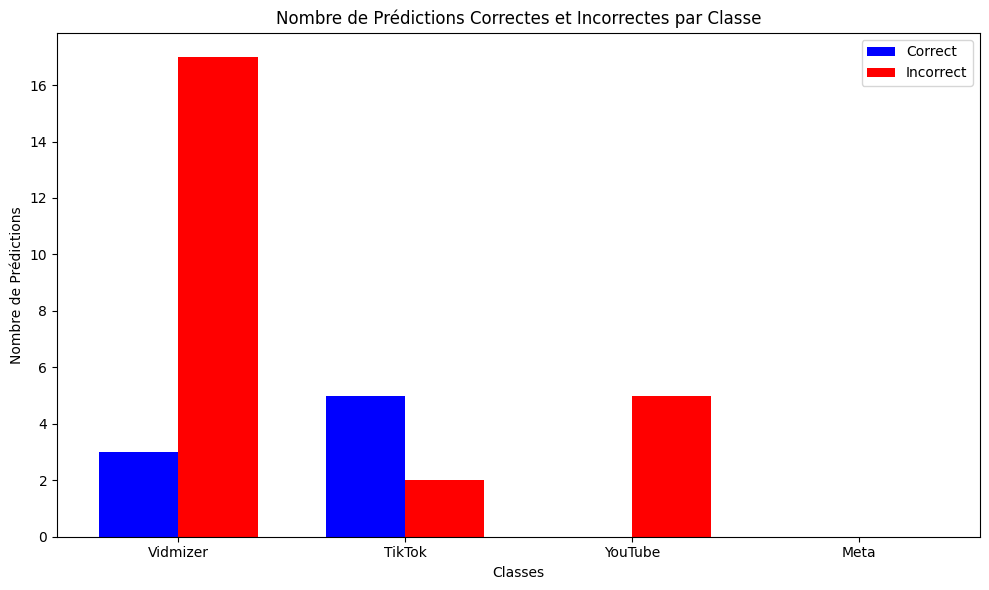

In [52]:
import matplotlib.pyplot as plt
import numpy as np

# Calculer le nombre de prédictions correctes et incorrectes pour chaque classe prédite
pred_counts = {0: {'correct': 0, 'incorrect': 0},
               1: {'correct': 0, 'incorrect': 0},
               2: {'correct': 0, 'incorrect': 0},
               3: {'correct': 0, 'incorrect': 0}}

for pred, truth, _ in eval_labels:
    if pred == truth:
        pred_counts[pred]['correct'] += 1
    else:
        pred_counts[pred]['incorrect'] += 1

# Préparation des données pour le bar chart
classes = ['Vidmizer', 'TikTok', 'YouTube', 'Meta']
correct_counts = [pred_counts[i]['correct'] for i in range(4)]
incorrect_counts = [pred_counts[i]['incorrect'] for i in range(4)]

bar_width = 0.35
index = np.arange(len(classes))

# Création du bar chart
plt.figure(figsize=(10, 6))
bar1 = plt.bar(index, correct_counts, bar_width, color='b', label='Correct')
bar2 = plt.bar(index + bar_width, incorrect_counts, bar_width, color='r', label='Incorrect')

plt.xlabel('Classes')
plt.ylabel('Nombre de Prédictions')
plt.title('Nombre de Prédictions Correctes et Incorrectes par Classe')
plt.xticks(index + bar_width / 2, classes)
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
# correct = 0
# rien = 0
# total = 0
# mal_predit = 0

# for duo_compare in eval_labels :
#   total+= 1
#   if duo_compare[0] == duo_compare[1]:
#     correct +=1
#   if duo_compare[0] == 3
#     rien += 0
#   else :
#     mal_predit += 1


# print ('Accuracy Test sur les classifier en Cascade : ', correct / total)

correct = 0
rien = 0
total = 0
mal_predit = 0

for duo_compare in eval_labels:
    total += 1
    if duo_compare[0] == duo_compare[1]:
        correct += 1
    elif duo_compare[0] == 3:
        rien += 1
    else:
        mal_predit += 1

print('Accuracy des classifiers en Cascade :', correct / total)
print('Nombre de Meta classifiés :', rien)
print('Nombre de mal prédits :', mal_predit)



